In [1]:
import pandas as pd
import re
from sentence_transformers import SentenceTransformer
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
df_data = pd.read_csv("../data/reviews_clean.csv")

In [3]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

model_path = "../indoBert_model/"

model_dir = model_path
tokenizer_dir = model_path

model = AutoModelForSequenceClassification.from_pretrained(model_dir, num_labels=3)
tokenizer = AutoTokenizer.from_pretrained(tokenizer_dir)

classifier = pipeline("text-classification", model=model, tokenizer=tokenizer)

Device set to use cpu


In [4]:
df_data['has_review'] = (
    df_data['review_text'].notna() &
    (df_data['review_text'].str.strip() != "")
)


In [5]:
df = pd.read_csv("../data/colloquial-indonesian-lexicon.csv")

# Ubah jadi dictionary: {"slang": "formal"}
custom_slang = dict(zip(df['slang'], df['formal']))

#Fungsi normalisasi slang
def normalize_slang(text):
    words = text.split()
    normalized = [custom_slang.get(w.lower(), w) for w in words]
    
    return " ".join(normalized)

In [ ]:
def normalize_domain(text):
    domain_map = {
        r'\bcar\s*free\s*day\b': 'car_free_day',
        r'\bcfd\b': 'car_free_day',
        
        r'\bpkl\b': 'pedagang kaki lima',
        
        r'\bair\s*mancur\b': 'air_mancur',
        r'\balun\s*alun\b': 'alun_alun',

        # r'\barea\s*bermain\b': 'playground',
        # r'\btaman\s*bermain\b': 'playground',
        # r'\bmainan\s*anak\b': 'playground',

        r'\bjoging\b': 'jogging',
        r'\bjogging\s*track\b': 'jogging',
        # r'\bjalan\s*santai\b': 'jogging',
        r'\blari\b': 'jogging'
    }

    for pattern, replacement in domain_map.items():
        text = re.sub(pattern, replacement, text)

    return text


In [7]:
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

factory = StopWordRemoverFactory()
stopwords = factory.get_stop_words()
stemmer = StemmerFactory().create_stemmer()

with open("../data/combined_stop_words.txt", "r", encoding="utf-8") as f:
    custom_stopwords = f.read().splitlines()

general_words={
# 'alun',
# 'lumajang',
# 'kota',
# 'taman'
# "bagus", "banget", "indah", "cukup",
#     "enak", "mantap", "oke", "lumayan"
}

stopwords.extend(custom_stopwords)
stopwords.extend(general_words)
stopwords.append("nya")

def remove_stopwords(tokens):
    return [w for w in tokens if w not in stopwords]



In [8]:
def wordcloud_preprocess(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()

    text = re.sub(r'http\S+|www\S+', '', text)
    text = re.sub(r'[^a-z_\s]', ' ', text)

    text = normalize_slang(text)
    text = normalize_domain(text)

    tokens = text.split()

    tokens = [t for t in tokens if len(t) > 2]
    tokens = remove_stopwords(tokens)

    return " ".join(tokens)


In [9]:
import re

def preprocess_indobert(text):
    if not isinstance(text, str):
        return ""
    
    # 1. lowercase 
    text = text.lower()

    # 2. normalisasi tanda hubung
    text = text.replace("-", " ")

    # 3. hapus URL
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)

    # 4. hapus emoji
    text = re.sub(
        "["
        u"\U0001F600-\U0001F64F"
        u"\U0001F300-\U0001F5FF"
        u"\U0001F680-\U0001F6FF"
        u"\U0001F1E0-\U0001F1FF"
        "]+",
        "",
        text
    )

    # 5. hapus karakter aneh (tapi JANGAN hapus kata)
    text = re.sub(r'[^a-z0-9\s]', ' ', text)

    # 6. normalisasi slang (PENTING)
    text = normalize_slang(text)

    # 7. rapikan spasi
    text = re.sub(r'\s+', ' ', text).strip()

    return text


In [10]:
df_data['clean_review']=df_data['review_text'].apply(preprocess_indobert)

In [11]:
from langdetect import detect

def detect_lang(text):
    try:
        return detect(text)
    except:
        return "unknown"

df_data["lang"] = df_data["clean_review"].astype(str).apply(detect_lang)


In [12]:
df_data['word_cloud']=df_data['review_text'].apply(wordcloud_preprocess)

In [13]:
# default
df_data['sentiment_type'] = 'rating_only'

# hanya yang ada review
texts = df_data.loc[df_data['has_review'], 'clean_review'].tolist()
results = classifier(texts, batch_size=16)
labels = [r['label'].lower() for r in results]

df_data.loc[df_data['has_review'], 'sentiment_type'] = labels


In [14]:
df_data['sentiment_type'].unique()

array(['negative', 'positive', 'neutral', 'rating_only'], dtype=object)

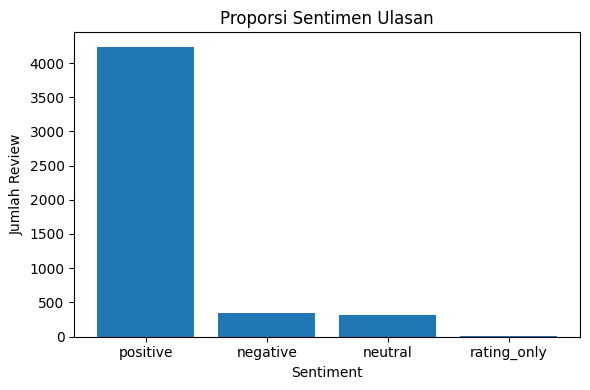

In [15]:
import matplotlib.pyplot as plt

sentiment_counts = df_data['sentiment_type'].value_counts()

plt.figure(figsize=(6,4))
plt.bar(sentiment_counts.index, sentiment_counts.values)
plt.xlabel("Sentiment")
plt.ylabel("Jumlah Review")
plt.title("Proporsi Sentimen Ulasan")
plt.tight_layout()
plt.show()

In [16]:
df_data[df_data['sentiment_type']=='negative']

,review_id,rating,date,review_text,date_parsed,year,has_review,clean_review,lang,word_cloud,sentiment_type
0,Ci9DQUlRQUNvZENodHljRjlvT205MVoySk1jbE5uVEVaeV...,2,3 months ago,Kursi dan beberapa permainan perlu diberikan p...,2025-10-18 08:03:10.584460,2025,True,kursi dan beberapa permainan perlu diberikan p...,id,kursi permainan diberikan perawatan perawatan ...,negative
7,Ci9DQUlRQUNvZENodHljRjlvT2s1TFNFUmFTWGN5VWxRMm...,4,5 months ago,"Ada playground, beberapa alat gym, rumah burun...",2025-08-18 08:03:10.585486,2025,True,ada playground beberapa alat gym rumah burung ...,id,playground alat gym rumah burung dara toilet b...,negative
9,ChZDSUhNMG9nS0VJQ0FnSUNwNzhLUmJnEAE,1,Edited a year ago,Contoh sdm yang terbelakang. Sampah kian hari ...,2026-01-18 08:03:10.585486,2026,True,contoh sdm yang terbelakang sampah kian hari k...,id,contoh sdm terbelakang sampah kian kian menump...,negative
19,Ci9DQUlRQUNvZENodHljRjlvT21kZlZrMXVjRXQzYzFSTl...,1,6 months ago,Ini aga beda bukan diusir satpol pp tapi diusi...,2025-07-18 08:03:10.587582,2025,True,ini aga beda bukan diusir satpol pp tapi diusi...,id,aga beda diusir satpol diusir pedagang jualan ...,negative
36,ChdDSUhNMG9nS0VJQ0FnSUNtcmVtZ193RRAB,3,4 years ago,Sudah lama tidak kesini. Banyak sekali perubah...,2022-01-18 08:03:10.587582,2022,True,sudah lama tidak kesini banyak sekali perubaha...,id,kesini perubahan kesannya terawat sarana olahr...,negative
...,...,...,...,...,...,...,...,...,...,...,...
4855,ChdDSUhNMG9nS0VJQ0FnSUNxaE5iTzF3RRAB,4,4 years ago,Beringin tumbang,2022-01-18 08:03:10.739630,2022,True,beringin tumbang,id,beringin tumbang,negative
4856,ChdDSUhNMG9nS0VJQ0FnSUNzbV9QRmtnRRAB,5,5 years ago,Rumah sendiri,2021-01-18 08:03:10.739630,2021,True,rumah sendiri,id,rumah,negative
4867,ChZDSUhNMG9nS0VJQ0FnSUNneE1QV0l3EAE,2,9 years ago,Belum kelar,2017-01-18 08:03:10.739630,2017,True,belum kelar,id,kelar,negative
4894,ChdDSUhNMG9nS0VJQ0FnSUNleHJ6QzZBRRAB,3,3 years ago,Jelek,2023-01-18 08:03:10.739630,2023,True,jelek,hr,jelek,negative


In [46]:
mask = df_data['review_text'].str.contains(r'pedagang', case=False, na=False)
df_data.loc[mask, 'word_cloud'].iloc[0]

'alun_alun lumajang fasilitas relatif lengkap spot olah raga play ground food court hampir sekeliling jalan alun_alun car_free_day mungkin pembenahan penataan pedagang relatif rapi lalang kendaraan dikontrol ketat'

In [38]:
wordcloud_preprocess(df_data.loc[mask, 'word_cloud'].iloc[0])

'bersih playground anak anak berolahraga kulineran nonkrong berjualana alun_alun oiya kalo pagi car_free_day pilihan kuliner olahraga pagi disini'

In [35]:
normalize_domain(df_data.loc[mask, 'word_cloud'].iloc[0])

'bersih playground anak anak berolahraga kulineran nonkrong berjualana alun_alun oiya kalo pagi car_free_day pilihan kuliner olahraga pagi disini'

In [20]:
import openpyxl
df_data.to_excel("../data/review_taman-kota.xlsx", index=False)